## Imports

In [ ]:
!pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git@v0.8.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git (to revision v0.8.7) to /tmp/pip-req-build-6jobyi3g
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-req-build-6jobyi3g
  Running command git checkout -q c47646c43dc3cb71812db08bdb3843cfa783d8cc


In [ ]:
!pip install -U opencv-python==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import zipfile
import datetime
import string
import glob
import math
import os

import numpy as np
import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import random

import keras_ocr

import jiwer # for CER

## Mount drive

In [ ]:
try:
  from google.colab import drive
  import os
  drive.mount('/content/drive')
  data_dir = 'drive/My Drive/Abto_camp/Project'
  os.makedirs(data_dir, exist_ok=True)
except ImportError:
  data_dir = '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Generating synthetic data

In [ ]:
import string
# Removed similar letters
ukr_letters = 'бвгґдєжзиїйклмнптуфцчшщьюяБГҐДЄЖЗИЇЙЛПУФЦЧШЩЬЮЯ'
en_letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabet = string.digits + ukr_letters + en_letters + ' '
recognizer_alphabet = ''.join(sorted(set(alphabet)))

In [ ]:
fonts = keras_ocr.data_generation.get_fonts(
    alphabet=alphabet,
    cache_dir=data_dir+'/data'
)

Looking for drive/My Drive/Abto_camp/Project/data/fonts.zip


Filtering fonts.: 100%|██████████| 2746/2746 [00:23<00:00, 114.93it/s]


In [ ]:
backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir+'/data')

Looking for drive/My Drive/Abto_camp/Project/data/backgrounds.zip


In [ ]:
def text_generator(alphabet, max_string_length):
    while True:
        sentence_len = np.random.randint(low = 1, high = max_string_length + 1)
        letter_indexes = np.random.randint(low = 0, high = len(alphabet), size = sentence_len)
        letter_list = [alphabet[letter_indexes[i]] for i in range(sentence_len)]
        sentence = ''.join(letter_list)
        yield sentence

In [ ]:
def text_generator_2(alphabet, max_string_length):
    while True:
        number_0 = '0'
        letter_ii = 'ї'
        letter_ii_upper = 'Ї'

        alphabet.replace('0', ''), alphabet.replace('ї', ''), alphabet.replace('Ї', '')
        alph = list(alphabet * 5 + number_0 * 2 + letter_ii * 8 + letter_ii_upper * 8)
        random.shuffle(alph)
        alphabet = ''.join(alph)

        sentence_len = np.random.randint(low = 1, high = max_string_length + 1)
        letter_indexes = np.random.randint(low = 0, high = len(alphabet), size = sentence_len)
        letter_list = [alphabet[letter_indexes[i]] for i in range(sentence_len)]
        sentence = ''.join(letter_list)

        yield sentence

In [ ]:
def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

The first generated validation image (below) contains: n
GoЦЄ
шl6F6


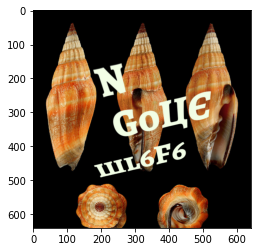

In [ ]:
max_string_length = 100
text_generator = text_generator(alphabet, max_string_length)

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator (
        height=640,
        width=640,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(50, 150),
        margin=50,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

## Load weights

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [ ]:
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights=None  # 'kurapan'
)
recognizer.model.load_weights(data_dir + '/weights' + '/last_one_good.h5')
recognizer.compile()

In [ ]:
for layer in recognizer.backbone.layers:
    layer.trainable = False

## Train the detector

In [ ]:
num_epochs = 10
weights_dir = data_dir + '/weights'

In [ ]:
detector_batch_size = 4
detector_basepath = os.path.join(weights_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=num_epochs,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size)
)

## Train the recognizer

This image contains: EЇ


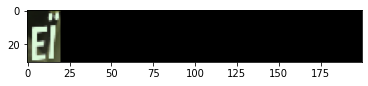

In [ ]:
max_length = 20
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [ ]:
recognition_num_epochs = 100
recognition_batch_size = 32
weights_dir = data_dir + '/weights'
recognizer_basepath = os.path.join(weights_dir, f'recognizer_50_16_300')  # {datetime.datetime.now().isoformat()}
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=False
    ) for image_generator in recognition_image_generators
]
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=recognition_num_epochs,
    steps_per_epoch=math.ceil(500),   # len(background_splits[0]) / recognition_batch_size
    callbacks=[
      tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
      tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
      tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(500),
    workers=1
)


## Plot losses

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

path = data_dir + '/weights/' + 'recognizer_100_32.csv'

df = pd.read_csv(path)
epochs = df['epoch'].values
train_loss = df['loss'].values
val_loss = df['val_loss'].values

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Obtaining metrics

In [ ]:
def recognizer_cer_from_generator(recognizer, generator, num_iter, case_sensitive = True):
    """Obtain avarage CER(Character Error Rate)

    Args:
        recognizer: recognizer model
        generator: generator of cropped images, ex. convert_image_generator_to_recognizer_input
        num_iter: number of iterations - aka number of samples
    """
    cer_arr = np.empty([num_iter], dtype=np.float128)
    for i in range(num_iter):
        image, ground_truth_text = next(generator)
        predicted_text = recognizer.recognize(image)
        if (not case_sensitive):
          predicted_text = predicted_text.lower()
          ground_truth_text = ground_truth_text.lower()
        cer_arr[i] = jiwer.cer(ground_truth_text, predicted_text)  
    return np.mean(cer_arr)

In [ ]:
train_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[0], len(background_splits[0]))
print(f'Train CER: {train_cer:.2f}')

In [ ]:
val_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[1], len(background_splits[1]))
print(f'Validation CER: {val_cer:.2f}')

In [ ]:
test_cer = recognizer_cer_from_generator(recognizer, recognition_image_generators[2], len(background_splits[2]))
print(f'Test CER: {test_cer:.2f}')

## Test images

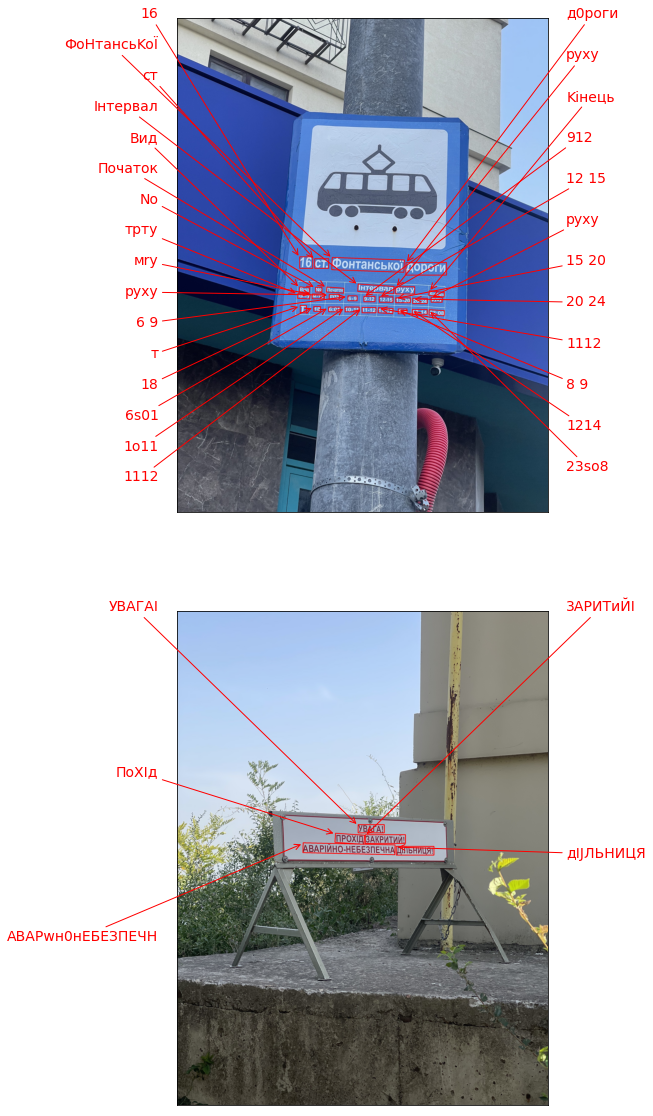

In [ ]:
import os

pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)

dir = data_dir + '/data/Test_Photos/'
imgs = [dir + path_name for path_name in os.listdir(dir)]

images = [
    keras_ocr.tools.read(path) for path in [
        dir + '1.jpg',
        dir + '2.jpg'

    ]
]

prediction_groups = pipeline.recognize(images)

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image, predictions, ax=ax)

In [ ]:
# https://stackoverflow.com/questions/38654302/how-can-i-sort-contours-from-left-to-right-and-top-to-bottom

prediction = prediction_groups[0]
max_height = np.max([abs(bbox[1][0][1] - bbox[1][1][1]) for bbox in prediction])
print(max_height)
pred_sorted = sorted(prediction, key=lambda x: x[1][0][1])
for pred in pred_sorted:
    print(pred[1][0][1])
line_top = pred_sorted[0][1][0][1]
line = 1
by_line = []

for bbox in pred_sorted:
    if bbox[1][0][1] > line_top + max_height:
        line_top = bbox[1][0][1]
        line += 1

    by_line.append((line, bbox))

bbox_sorted = [bbox for line, bbox in sorted(by_line)]

# for bbox in bbox_sorted:
#     print(bbox[1][0][1])

In [ ]:
# [[l, t], [r, t], [r, b], [l, b]]
import numpy as np
preds, boxes = [], []

for prediction in prediction_groups[0]:
    preds.append(prediction[0])
    boxes.append(prediction[1])

# r = []
# for bbox in boxes:
#     l = bbox[0][0]
#     t = bbox[0][1]
#     r.append((l ** 2 + t ** 10) ** 0.5)

# # r = [(coord[0]**2 + coord[1]**2)**0.5 for bbox in boxes for coord in bbox[0]]

# text = [word for _, word in sorted(zip(r, preds))]

# print(text)